In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from analysis_dependencies import get_wrf_slp
from analysis_dependencies import get_wrf_rh
from analysis_dependencies import gen_wrf_proj
from analysis_dependencies import gen_cartopy_proj
import datetime
import wrf
import cartopy
from cartopy import crs as ccrs
from cartopy import feature as cfeature

In [2]:
# dim_coord_swap: assign dimension names and coordinate values from one xarray.Dataset() variable
#                 to another xarray.Dataset() variable
#
# INPUTS:
#
# recDat: xarray.Dataset() object receiving dimension names and coordinates from donor
# donDat: xarray.Dataset() object donating dimension names and coordinates to receiver
#
# OUTPUTS:
#
# recDat input xarray.Dataset(), with dimension names and coordinate values from donDat
#
# DEPENDENCIES:
#
# wrf-python
# xarray (implicit, also dependency of wrf-python)
#
# NOTE: This function presumes recDat and donDat *should* have identical dimension names
#       and coordinate values. If the number of dimensions does not match, will error and
#       return without swapping dimensions/coordinates
def dim_coord_swap(recDat,donDat):
    import wrf
    # check if number of dimensions of recDat and donDat match
    # this is the only sanity check applied, if it passes we are
    # assuming that the dimension names should be identical AND
    # both datasets should have the same coordinate values
    if len(recDat.dims) == len(donDat.dims):
        # create dictionary for swapping recDat dimensions with
        # donDat dimensions
        dimDict = {}
        for i in range(len(recDat.dims)):
            dimDict[recDat.dims[i]] = donDat.dims[i]
        # swap dimensions
        recDat=recDat.rename(dimDict)
        # swap coordinates
        recDat=recDat.assign_coords(donDat.coords)
        return recDat
    else:
        print('number of receiever dimensions ({:d})'.format(len(recDat.dims)) +
              ' does not match number of donor dimensions ({:d})'.format(len(donDat.dims)))
        print('no dimension/coordinate swapping applied')
        return recDat

In [3]:
# gen_wrf_proj: generate a wrf.WrfProj() object from metadata contained in a WRF file
#
# INPUTS:
#
# wrfHDL: WRF file netCDF4.Dataset() handle
#
# OUTPUTS:
#
# wrfProjObj: wrf.WrfProj() object containing WRF grid's map projection properties.
#
# DEPENDENCIES:
#
# netCDF4.Dataset()
# wrf.WrfProj()
def gen_wrf_proj(wrfHdl):
    from netCDF4 import Dataset
    from wrf import WrfProj
    
    return WrfProj(map_proj=wrfHdl.MAP_PROJ,
                   truelat1=wrfHdl.TRUELAT1,
                   truelat2=wrfHdl.TRUELAT2,
                   moad_cen_lat=wrfHdl.MOAD_CEN_LAT,
                   stand_lon=wrfHdl.STAND_LON,
                   pole_lat=wrfHdl.POLE_LAT,
                   pole_lon=wrfHdl.POLE_LON,
                   dx=wrfHdl.DX,
                   dy=wrfHdl.DY
                  )
# gen_cartopy_proj: generate a cartopy.crs() object from metadata contained in a WRF file
#
# INPUTS:
#
# wrfHDL: WRF file netCDF4.Dataset() handle
#
# OUTPUTS:
#
# crsProjObj: cartopy.crs() object containing WRF grid's map projection properties
#
# DEPENDENCIES:
#
# netCDF4.Dataset()
# cartopy.crs()
#
# NOTES:
# I am following the advice given in this post to explicitly define an Earth SPHERE for
# the projection by defining the cartopy.crs.Globe() with a semimajor_axis and
# semiminor_axis of 6370000. m to match WRF's definition of the Earth as a sphere
# rather than as an ellipsoid.
# https://fabienmaussion.info/2018/01/06/wrf-projection/
# I don't see any significant difference with/without the explicit definition of an
# Earth sphere (lat/lon pass back and forth between either projection and
# cartopy.crs.PlateCarree() with differences on the order of 1.0e-9 degrees), but
# since this is apparently the correct way to do it and it doesn't generate large
# differences, I'm going to go with it in-case my proj <--> PlateCarree tests are
# being done incorrectly. I'm doing no harm with it, as far as I can tell.
def gen_cartopy_proj(wrfHDL):
    from netCDF4 import Dataset
    from cartopy import crs as ccrs
    # WRF is assumed on a Lambert Conformal projection, if it's not the routine
    # will report an error and return None. You can add more projection options
    # as you run into them, but the most common projection is Lambert Conformal
    # so I'm only coding that one here.
    if (wrfHDL.MAP_PROJ == 1) & (wrfHDL.MAP_PROJ_CHAR == "Lambert Conformal"):
        return ccrs.LambertConformal(
                                     central_longitude=wrfHDL.CEN_LON,
                                     central_latitude=wrfHDL.CEN_LAT,
                                     standard_parallels=(wrfHDL.TRUELAT1,wrfHDL.TRUELAT2),
                                     globe=ccrs.Globe(
                                                      ellipse='sphere',
                                                      semimajor_axis=6370000.,
                                                      semiminor_axis=6370000.
                                                     )
                                    )
    else:
        print('FAILED: UNKNOWN PROJECTION ENCOUNTERED:')
        print('.MAP_PROJ={:d}'.format(wrfHDL.MAP_PROJ))
        print('.MAP_PROJ_CHAR=' + wrfHDL.MAP_PROJ_CHAR)
        return None

In [2]:
unpDir = '/home/bhoover/UWAOS/WRF_QOIP/data_repository/final_runs/march2020/R_mu/unperturbed/'
ptdDir = '/home/bhoover/UWAOS/WRF_QOIP/data_repository/final_runs/march2020/R_mu/negative/uvTq/ptdi14/'
arcDir = '/home/bhoover/UWAOS/WRF_QOIP/data_repository/case_archives/march2020/R_mu/negative/uvTq/'
arcPtd = '14'
dtInit = datetime.datetime(2020, 3, 6, 12)

In [3]:
fcstHr = 24
dtFcst = dtInit + datetime.timedelta(hours=fcstHr)
dtInitStr = datetime.datetime.strftime(dtInit,'%Y-%m-%d_%H:00:00')
dtFcstStr = datetime.datetime.strftime(dtFcst,'%Y-%m-%d_%H:00:00')
unpWRFInputFile = arcDir + 'wrfinput_d01_unpi00'
ptdWRFInputFile = arcDir + 'wrfinput_d01_ptdi' + arcPtd
unpFileInit = unpDir + 'wrfout_d01_' + dtInitStr
ptdFileInit = ptdDir + 'wrfout_d01_' + dtInitStr
unpFileFcst = unpDir + 'wrfout_d01_' + dtFcstStr
ptdFileFcst = ptdDir + 'wrfout_d01_' + dtFcstStr
unpHdlInput = Dataset(unpWRFInputFile)
ptdHdlInput = Dataset(ptdWRFInputFile)
unpHdlInit = Dataset(unpFileInit)
ptdHdlInit = Dataset(ptdFileInit)
unpHdlFcst = Dataset(unpFileFcst)
ptdHdlFcst = Dataset(ptdFileFcst)

In [4]:
lat = np.asarray(unpHdlInit.variables['XLAT']).squeeze()
lon = np.asarray(unpHdlInit.variables['XLONG']).squeeze()
fix = np.where(lon < 0.)
lon[fix] = lon[fix] + 360.

unpSLPInput = np.asarray(get_wrf_slp(unpHdlInput)).squeeze()
ptdSLPInput = np.asarray(get_wrf_slp(ptdHdlInput)).squeeze()
unpSLPInit = np.asarray(get_wrf_slp(unpHdlInit)).squeeze()
ptdSLPInit = np.asarray(get_wrf_slp(ptdHdlInit)).squeeze()
unpSLPFcst = np.asarray(get_wrf_slp(unpHdlFcst)).squeeze()
ptdSLPFcst = np.asarray(get_wrf_slp(ptdHdlFcst)).squeeze()

unpRHInput = np.asarray(get_wrf_rh(unpHdlInput)).squeeze()
ptdRHInput = np.asarray(get_wrf_rh(ptdHdlInput)).squeeze()
unpRHInit = np.asarray(get_wrf_rh(unpHdlInit)).squeeze()
ptdRHInit = np.asarray(get_wrf_rh(ptdHdlInit)).squeeze()

unpPInput = np.asarray(wrf.getvar(unpHdlInput,'p')).squeeze()
ptdPInput = np.asarray(wrf.getvar(ptdHdlInput,'p')).squeeze()
unpPInit = np.asarray(wrf.getvar(unpHdlInit,'p')).squeeze()
ptdPInit = np.asarray(wrf.getvar(ptdHdlInit,'p')).squeeze()

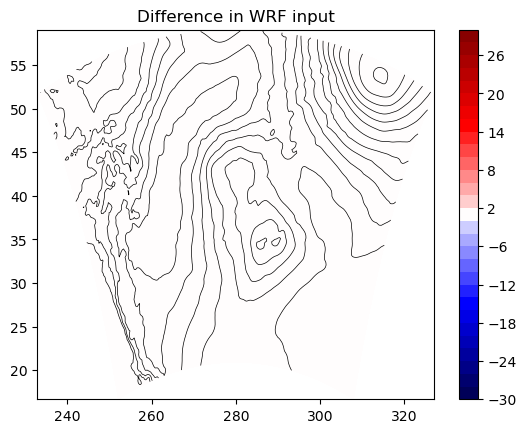

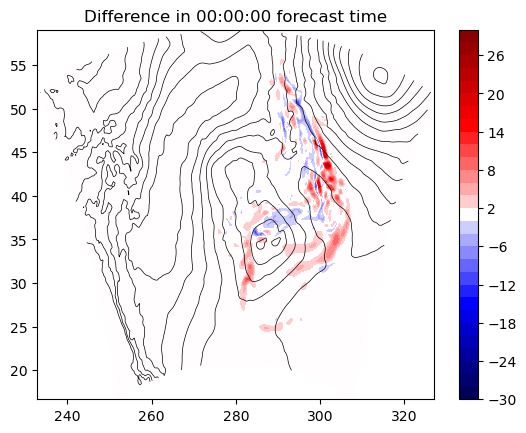

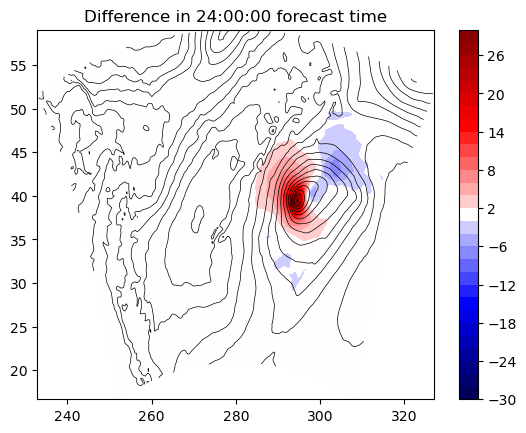

In [5]:
shdrng = np.arange(-30.,30.1,2.)
mask = np.ones((np.shape(shdrng)),dtype='bool')
mask[np.where(shdrng==0.)] = False

shd=plt.contourf(lon,lat,ptdSLPInput-unpSLPInput,shdrng[mask],cmap='seismic')
plt.contour(lon,lat,unpSLPInput,np.arange(960.,1042.1,4.),colors='black',linewidths=0.5)
plt.colorbar(mappable=shd)
plt.title('Difference in WRF input')
plt.show()

shd=plt.contourf(lon,lat,ptdSLPInit-unpSLPInit,shdrng[mask],cmap='seismic')
plt.contour(lon,lat,unpSLPInit,np.arange(960.,1042.1,4.),colors='black',linewidths=0.5)
plt.colorbar(mappable=shd)
plt.title('Difference in 00:00:00 forecast time')
plt.show()

shd=plt.contourf(lon,lat,ptdSLPFcst-unpSLPFcst,shdrng[mask],cmap='seismic')
plt.contour(lon,lat,unpSLPFcst,np.arange(960.,1042.1,4.),colors='black',linewidths=0.5)
plt.colorbar(mappable=shd)
plt.title('Difference in ' + str(fcstHr) + ':00:00 forecast time')
plt.show()

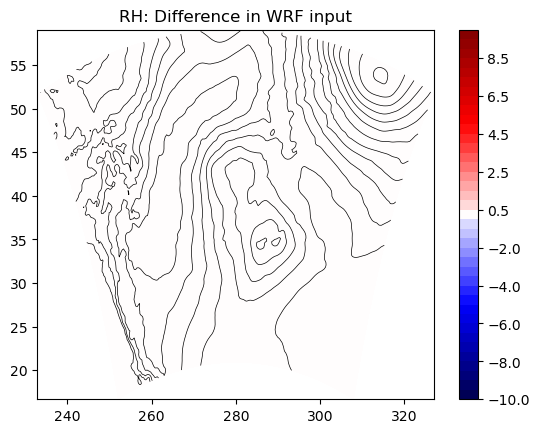

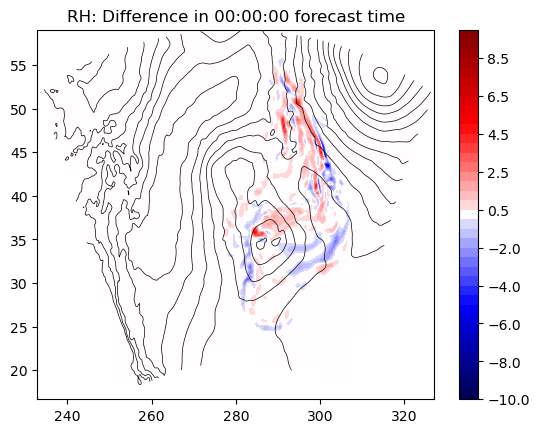

In [6]:
k = 0

shdrng = np.arange(-10.,10.1,0.5)
mask = np.ones((np.shape(shdrng)),dtype='bool')
mask[np.where(shdrng==0.)] = False

shd=plt.contourf(lon,lat,ptdRHInput[k,:,:].squeeze()-unpRHInput[k,:,:].squeeze(),shdrng[mask],cmap='seismic')
plt.contour(lon,lat,unpSLPInit,np.arange(960.,1042.1,4.),colors='black',linewidths=0.5)
plt.colorbar(mappable=shd)
plt.title('RH: Difference in WRF input')
plt.show()

shd=plt.contourf(lon,lat,ptdRHInit[k,:,:].squeeze()-unpRHInit[k,:,:].squeeze(),shdrng[mask],cmap='seismic')
plt.contour(lon,lat,unpSLPInit,np.arange(960.,1042.1,4.),colors='black',linewidths=0.5)
plt.colorbar(mappable=shd)
plt.title('RH: Difference in 00:00:00 forecast time')
plt.show()

In [7]:
proj=gen_wrf_proj(unpHdlInit)
xbeg=wrf.CoordPair(lat=30.,lon=280.)
xend=wrf.CoordPair(lat=45.,lon=310.)

rh=get_wrf_rh(unpHdlInit)
#rh=dim_coord_swap(rh,wrf.getvar(unpHdlInit,'p'))

unpX = wrf.vertcross(field3d=rh,
                     vert=wrf.getvar(unpHdlInit,'p'),
                     levels=np.arange(10000.,102000.1,5000.),
                     missing=np.nan,
                     wrfin=unpHdlInit,
                     stagger='m',
                     projection=proj,
                     start_point=xbeg,
                     end_point=xend,
                     latlon=True
                     )
pointLats=[]
pointLons=[]
for point in unpX.xy_loc.values:
    pointLatLonStr = point.latlon_str().split(', ')
    pointLats.append(float(pointLatLonStr[0]))
    pointLons.append(float(pointLatLonStr[1]))

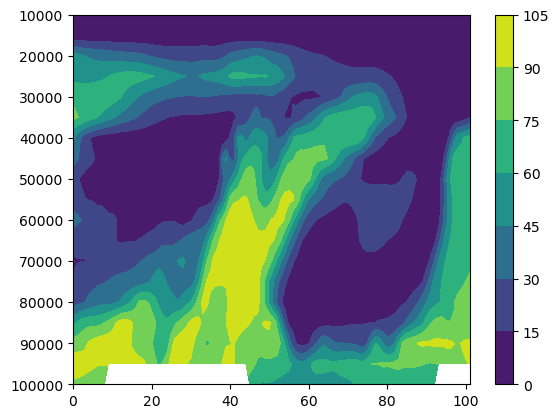

In [8]:
plt.contourf(np.arange(len(pointLats)),np.arange(10000.,102000.1,5000.),unpX)
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

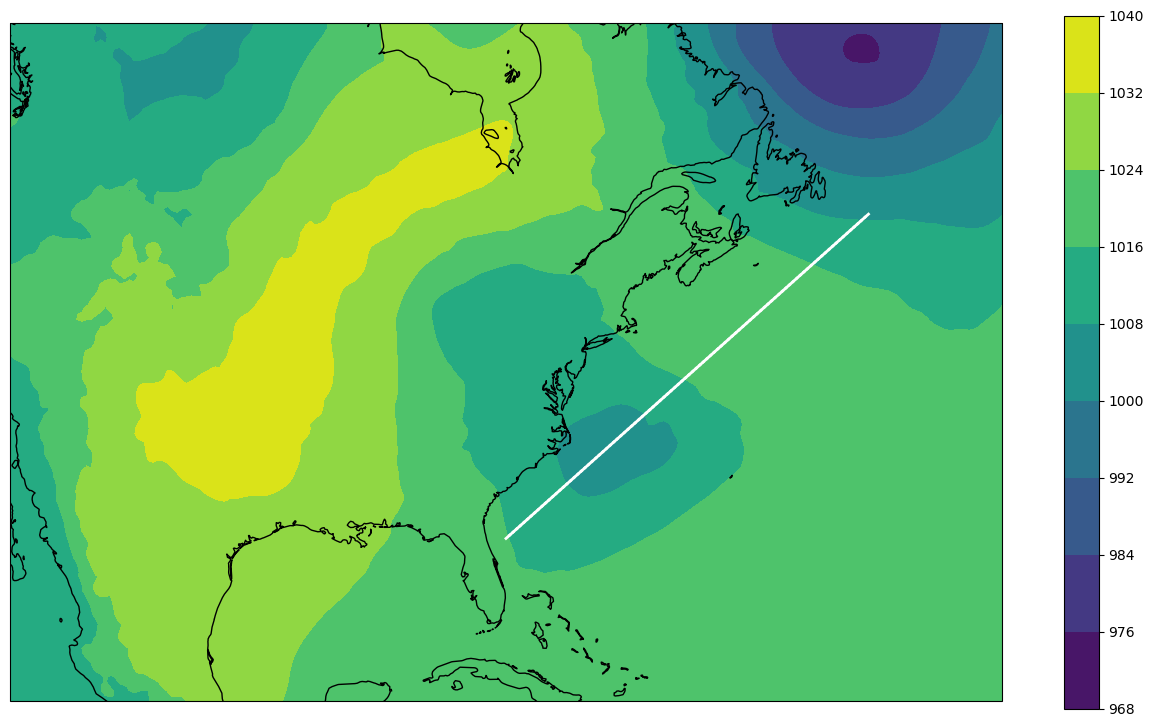

In [9]:
dat_proj = gen_cartopy_proj(unpHdlInit)
plot_proj = ccrs.PlateCarree()
fig=plt.figure(figsize=(16,9))
ax=plt.axes(projection=dat_proj)
shd=ax.contourf(lon,lat,unpSLPInit,transform=plot_proj,zorder=0)
fig.colorbar(ax=ax,mappable=shd)
for i in range(len(pointLons)-1):
    lin=ax.plot((pointLons[i],pointLons[i+1]),(pointLats[i],pointLats[i+1]),color='w',linewidth=2.,transform=plot_proj)
ax.add_feature(cfeature.COASTLINE,zorder=1)
plt.show()